In [1]:
import torch 
import os
import numpy as np
import scipy as sp
import scipy.io as sio
# import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
#from net.base_net import CuiNet,DeepSpectraCNN,ResNet18_1D,ViT_1D,FullyConvNet
from net.base_net import CuiNet,CuiNetJCB1,CuiNetJCB3
from utils.testing import test                      # ligne rajoutée
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test 
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split

# JC pour importer les fichiers tabulés
import numpy as np
import pandas as pd
import sys 

import math


2025-01-27 14:25:20.437698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737984320.719507    4519 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737984320.805403    4519 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 14:25:22.080304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# un lien relatif permet de placer le répertoire Deep-chemometrics-jcb n'importe où sur le disque
local_path=os.getcwd() + '/data/rmn_196'

# la première ligne commentée est celle valable pour galaxy



# CHOIX DES DONNEES RMN ---------

# données alignées + 2101 valeurs (simufiltre)
local_path_xcal=local_path + '/xtrain_rmn.tab'
local_path_xtest=local_path + '/xtest_rmn.tab'

# données non alignées + 2101 valeurs (1/50)
#local_path_xcal=local_path + '/xcal_2101_nonaligne.tab'
#local_path_xtest=local_path+ '/xval_2101_nonaligne.tab'

# données non alignées + 105001 valeurs
#local_path_xcal=local_path + '/xcal_105001_nonaligne.tab'
#local_path_xtest=local_path + '/xval_105001_nonaligne.tab'

# ---------------------------------------



#X_train=pd.read_csv("${Xdata.file_name}", sep="\t", header=0)
Xcal=pd.read_csv(local_path_xcal, sep="\t", header=0)
Xcal.drop(Xcal.columns[0],axis=1,inplace=True)

#Y_train=pd.read_csv("${Ydata.file_name}", sep="\t", header=0)
local_path_ycal=local_path+'/ytrain_rmn.tab'
Ycal=pd.read_csv(local_path_ycal, sep="\t", header=0)

#X_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
Xtest=pd.read_csv(local_path_xtest, sep="\t", header=0)
Xtest.drop(Xtest.columns[0],axis=1,inplace=True)

#Y_test =pd.read_csv("${Xdata_val.file_name}", sep="\t", header=0)
local_path_ytest=local_path+'/ytest_rmn.tab'
Ytest=pd.read_csv(local_path_ytest, sep="\t", header=0)

## partie à décommenter pour galaxy
#Y_column=${Ycolumn}-1
#Y_column_val=${Ycolumn_val}-1   ## debut a 0

Ycal=Ycal.iloc[:,1:2]
Ytest=Ytest.iloc[:,1:2]



In [4]:
# ----------------------------------------------------------------        JCB 22jan25
# ajustement de la dimension des matrices Xcat et Xtest 
# pour etre compatibles avec les valeurs de kernel_size et stride 
# ---------------------------------------------------------------


# definition des valeurs de kernel_size et stride  ----------
# pour la première couche de convolution 
# valeurs utilisées pour ajuster le nombre de variables en entrée 
# de manière à obtenir un nombre entier pour la première couche 
kernel_size=11
stride=5

# cuinetJC1
kernel_size0=kernel_size;
stride0=stride;

# pcuionetJC3
kernel_size1=kernel_size;
stride1=stride;


# -----------------------------------------------------------

# calcul du nombre de variables compatible avec k.size et stride 
q=Xcal.shape[1]      # q = nombre de variables du spectre RMN
n=(q-kernel_size)/stride
qnew=math.floor(n)*stride + kernel_size
print(qnew)

# ajustement des nouvelles dimensions 
Xcal=Xcal.iloc[:,1:qnew-1]
Xtest=Xtest.iloc[:,1:qnew-1]

input_dims=math.floor(n)+1;

print(Xcal.shape)
#print(Xtest.shape)
#print(input_dims)

Ycal=np.squeeze(np.eye(2)[Ycal])
print(Ycal.shape)

2096
(147, 2094)
(147, 2)


In [5]:
print("X and Y testing set")
print(Ytest.shape)
print("convert to one hot encoding")
Ytest = np.squeeze(np.eye(2)[Ytest])
print(Xtest.shape)
print(Ytest.shape)

X and Y testing set
(49, 1)
convert to one hot encoding
(49, 2094)
(49, 2)


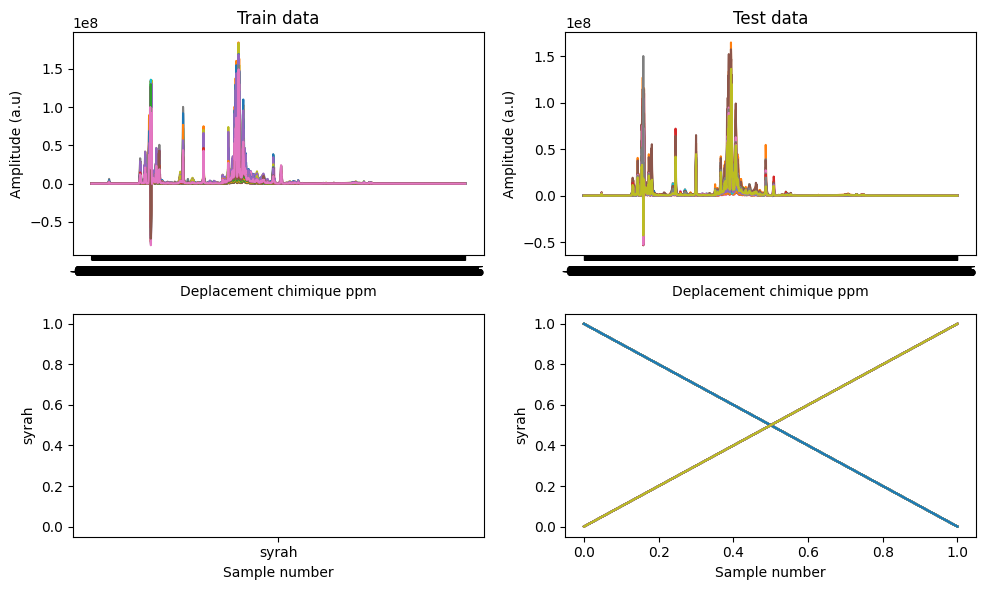

In [5]:
# PAS NECESSAIRE 


plt.figure(figsize=(10,6))

plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Deplacement chimique ppm')

plt.subplot(223)
# plt.plot(data['DM_cal'])
plt.plot(Ycal.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.subplot(224)
# plt.plot(data['DM_test'])
plt.plot(Ytest.T)
plt.ylabel('syrah')
plt.xlabel('Sample number')

plt.tight_layout()
plt.show()

In [6]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
# x_scale=data['wave'].astype(np.float32).reshape(-1,1)               data ne sert pas car fichier pas matlab

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
# print('wavelengths number = {}'.format(np.shape(x_scale)))          pas data -> pas xscale

Data set dimensions ----------------------------
Full Train set dims X Y = (147, 2094)	(147, 2)
Calibration set dims X Y = (117, 2094)	(117, 2)
val set dims X Y = (30, 2094)	(30, 2)
Test set dims X Y = (49, 2094)	(49, 2)


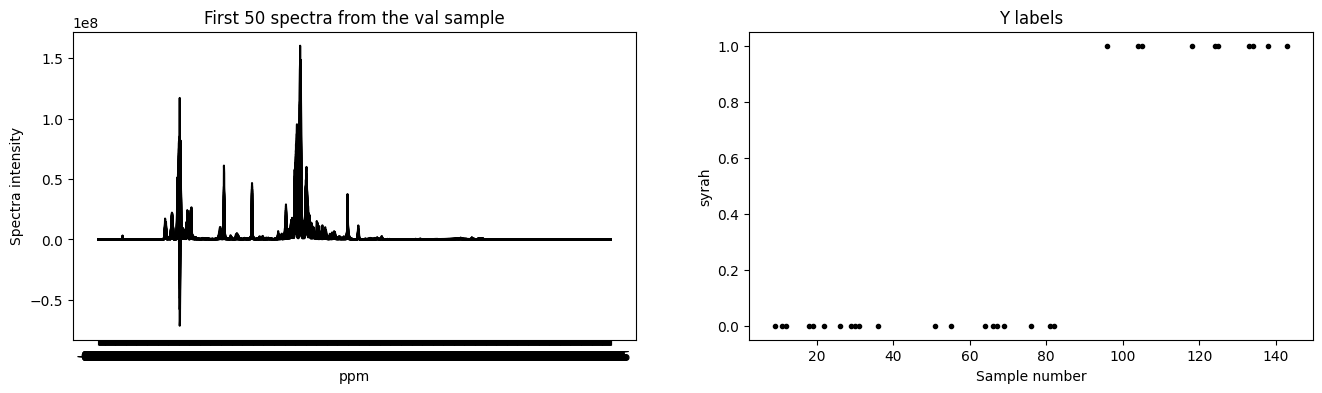

In [7]:
# PAS NECESSAIRE


## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
# plt.plot(x_val[:50,:].T,'k')
plt.plot(x_val.T,'k')           # .T est la transposée

plt.title('First 50 spectra from the val sample')
plt.xlabel(r'ppm')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('syrah')
plt.show()

In [7]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

# JC conversion en np.array
x_cal=np.array(x_cal)
y_cal=np.array(y_cal)
x_val=np.array(x_val)
y_val=np.array(y_val)
Xtest=np.array(Xtest)
Ytest=np.array(Ytest)

print(x_cal.shape)
print(y_cal.shape)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=1024, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=1024, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=1024, shuffle=True)


(117, 2094)
(117, 2)


kernel size
11
stride
5
/home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinet/_cuinet
CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=2090, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
Epoch 1/100 | Train Losses: y 0: 10.4054 | Validation Losses: y 0: 10.2925 | Metrics: F1 Score: 0.6667
Model saved at epoch 1 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinet/_cuinet_best.pth
Epoch 2/100 | Train Losses: y 0: 9.3211 | Validation Losses: y 0: 7.0965 | Metrics: F1 Score: 0.7667
Model saved at epoch 2 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinet/_cuinet_best.pth
Epoch 3/100 | Train Losses: y 0: 8.3523 | Validation Losses: y 0: 5.8171 | Metrics: F1 Score: 0.

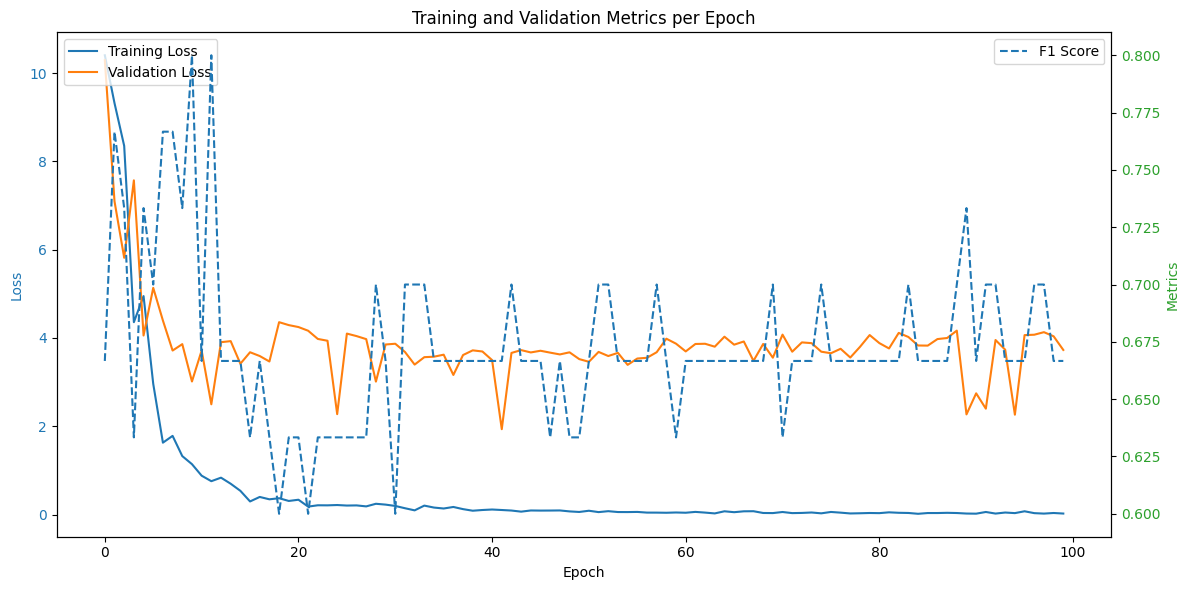

In [9]:
#CUINET

from net.base_net import CuiNet

# kernel_size et stride sont définis dans base_net.py / conv. layer 
# et écrasent les valeurs définies dans le script 
# kernel_size=5
# stride=1


print('kernel size')
print(kernel_size)
print('stride')
print(stride)
      


# define model parameters 

model_name ="_cuinet"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 100
save_interval = 10
out_dims=2
weight_decay=0.003/2
dropout=0.1

# repertoire de sauvegarde 

save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# CuiNet est un modèle pré-défini 
model = CuiNet(spec_dims, mean,std,dropout,out_dims)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)
#CuiNet(
#  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
#  (fc1): Linear(in_features=614, out_features=36, bias=True)
#  (fc2): Linear(in_features=36, out_features=18, bias=True)
#  (fc3): Linear(in_features=18, out_features=12, bias=True)
#  (out): Linear(in_features=12, out_features=1, bias=True)
#)

train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=True)

In [10]:

test(model,final_path,test_loader,classification=True)



(49, 2)
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.73      0.89      0.80        18

    accuracy                           0.84        49
   macro avg       0.83      0.85      0.83        49
weighted avg       0.85      0.84      0.84        49

[[25  6]
 [ 2 16]]


/home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB1/_cuinetJCB1
CuiNetJCB1(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(11,), stride=(5,))
  (fc1): Linear(in_features=417, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)


/home/pfp/Desktop/Deep-Chemometrics-jcb/net/base_net.py:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mean = nn.Parameter(torch.tensor(mean).float(),requires_grad=False)
/home/pfp/Desktop/Deep-Chemometrics-jcb/net/base_net.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.std = nn.Parameter(torch.tensor(std).float(),requires_grad=False)


Epoch 1/100 | Train Losses: y 0: 4.8999 | Validation Losses: y 0: 5.1872 | Metrics: F1 Score: 0.4667
Model saved at epoch 1 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB1/_cuinetJCB1_best.pth
Epoch 2/100 | Train Losses: y 0: 4.7907 | Validation Losses: y 0: 2.3528 | Metrics: F1 Score: 0.6333
Model saved at epoch 2 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB1/_cuinetJCB1_best.pth
Epoch 3/100 | Train Losses: y 0: 1.8169 | Validation Losses: y 0: 2.0832 | Metrics: F1 Score: 0.7000
Model saved at epoch 3 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB1/_cuinetJCB1_best.pth
Epoch 4/100 | Train Losses: y 0: 1.4756 | Validation Losses: y 0: 1.8019 | Metrics: F1 Score: 0.7333
Model saved at epoch 4 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB1/_cuinetJCB1_best.pth
Epoch 5/100 | Train Losses: y 0: 1.2706 | Validation Losses: y 0

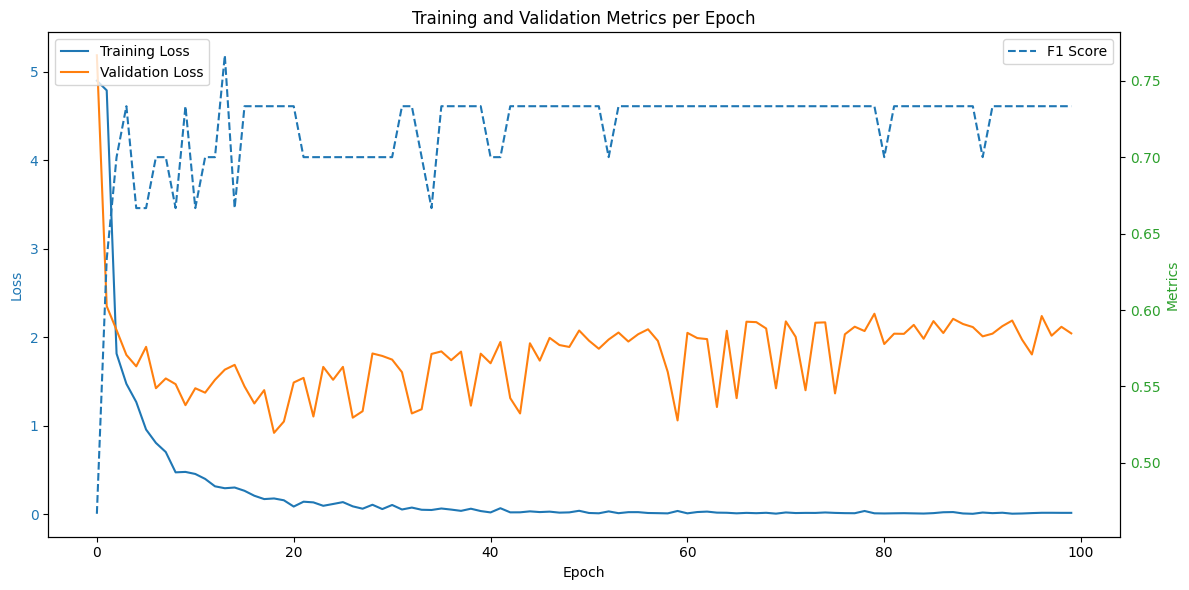

In [11]:
# CuiNETJCB1

# amélioration / CuiNet: les principaux paramètres ont été sortis des fonctions 
# ils sont maintenant regroupés et modifiables facilement 


# --------------------
# paramètres du modèle
# --------------------


# classification ou régression? 
classification=True

# nombre de dimensions en entrée = nombre de variables des spectres 
spec_dims = x_cal.shape[1]

# nombre de dimensions en sortie 
out_dims=2       

# LR = learning rate = taux d'apprentissage 
# + petit => + lent => + adapté à de peits jeux de données 
LR = 0.01

# num_epochs = critère proche d'un nombre de répétitions 
num_epochs = 100   # valeur très faible, juste pour faire tourner le modèlee; mettre 1000 ou plus 

# ?
save_interval = 10
dropout=0.1

# couche de convolution
# supprime car deja definis plus haut 
#kernel_size=13        # largeur de la fenetre glissante; un nombre impair 
#stride=5              # pas de déplacement de la fenetre glissante 

# --------------------------------------------
# attention BUG ne marche plus si stride>1 car la formule: dime. sortie convol. = dim. entrée - kernel_size + 1 ne marche plus !
# --------------------------------------------

# optimisation 
weight_decay=0.003/2

# sauvegarde des modèles  
model_name="_cuinetJCB1"
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# finalisation de la configuration de CuiNetJCB1
model = CuiNetJCB1(spec_dims, mean,std, dropout, out_dims,kernel_size0,stride0)

# optimisation 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)

# 

# critères d'évaluation de la performance du modèle 
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=classification)

In [12]:
print(model)

test(model,final_path,test_loader,classification=True)


CuiNetJCB1(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(11,), stride=(5,))
  (fc1): Linear(in_features=417, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
(49, 2)
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.70      0.89      0.78        18

    accuracy                           0.82        49
   macro avg       0.81      0.83      0.81        49
weighted avg       0.84      0.82      0.82        49

[[24  7]
 [ 2 16]]


/home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB3/_cuinetJCB3
CuiNetJCB3(
  (dropout): ManualDropout()
  (conv1d1): Conv1d(1, 1, kernel_size=(11,), stride=(5,))
  (conv1d2): Conv1d(1, 1, kernel_size=(3,), stride=(2,))
  (fc1): Linear(in_features=208, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
Epoch 1/100 | Train Losses: y 0: 1.8361 | Validation Losses: y 0: 1.2982 | Metrics: F1 Score: 0.5000
Model saved at epoch 1 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB3/_cuinetJCB3_best.pth
Epoch 2/100 | Train Losses: y 0: 0.9738 | Validation Losses: y 0: 1.1267 | Metrics: F1 Score: 0.6333
Model saved at epoch 2 to /home/pfp/Desktop/Deep-Chemometrics-jcb/data/rmn_196/data/rmn_196//models/_cuinetJCB3/_cuinetJCB3_best.pth
Epoch 3/100 | Train Losses: y 0: 0.6

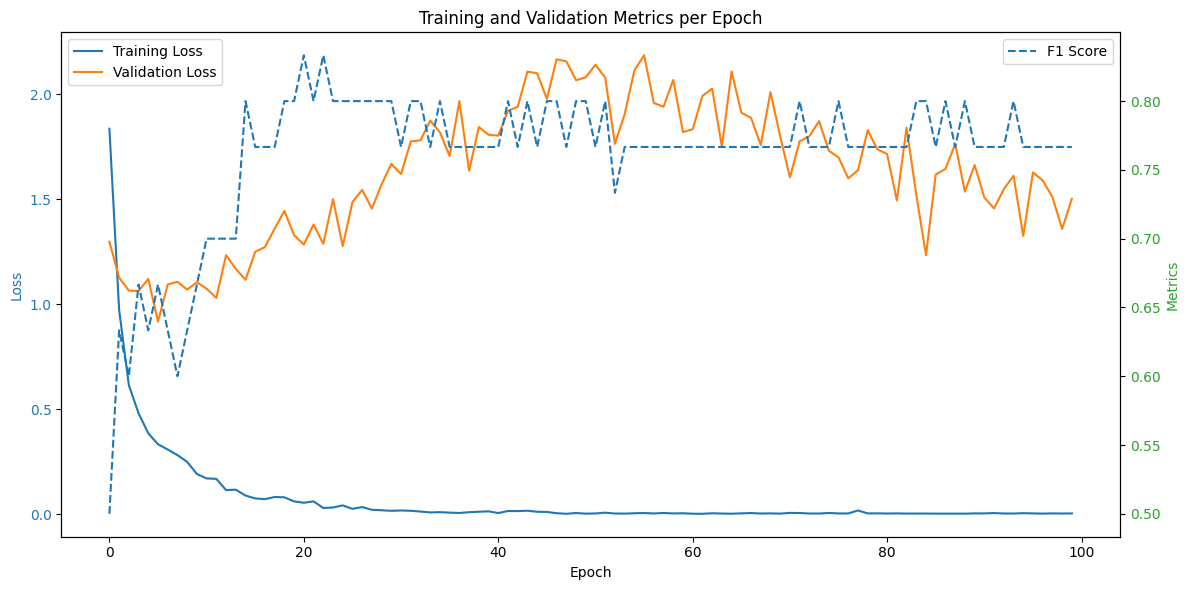

In [14]:
# CuiNETJCB3

# amélioration / CuiNetJCB1:  
# 2 couches de convolution, paramétrables pour kernel_size et stride de chaque couche de convolution 


# --------------------
# paramètres du modèle
# --------------------

# classification ou régression? 
classification=True

# nombre de dimensions en entrée = nombre de variables des spectres 
spec_dims = x_cal.shape[1]

# paramètres de la 2° couche de convolution 
kernel_size2=3
stride2=2

# nombre de dimensions en sortie 
out_dims=2    

# LR = learning rate = taux d'apprentissage 
# + petit => + lent => + adapté à de peits jeux de données 
LR = 0.01

# num_epochs = critère proche d'un nombre de répétitions 
num_epochs = 100   # valeur très faible, juste pour faire tourner le modèlee; mettre 1000 ou plus 

#                                                                   que représentent ces 2 valeurs??
save_interval = 10
dropout=0.1

# optimisation 
weight_decay=0.003/2

# sauvegarde des modèles  
model_name="_cuinetJCB3"
save_path = local_path + '/data/rmn_196/' + f'/models/{model_name}/' + model_name
print(save_path)

# finalisation de la configuration de CuiNetJCB1
model = CuiNetJCB3(spec_dims, mean,std, dropout, out_dims,kernel_size1,stride1,kernel_size2,stride2)

# optimisation 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)

# critères d'évaluation de la performance du modèle 
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_test =  nn.BCEWithLogitsLoss(reduction='none')

print(model)

# -----------------------------------------
# lancement de la procédure d'apprentissage 
# -----------------------------------------
train_losses, val_losses,metrics, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval,classification=classification)

In [15]:
print(model)

test(model,final_path,test_loader,classification=True)





CuiNetJCB3(
  (dropout): ManualDropout()
  (conv1d1): Conv1d(1, 1, kernel_size=(11,), stride=(5,))
  (conv1d2): Conv1d(1, 1, kernel_size=(3,), stride=(2,))
  (fc1): Linear(in_features=208, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
(49, 2)
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.59      0.56      0.57        18

    accuracy                           0.69        49
   macro avg       0.67      0.66      0.67        49
weighted avg       0.69      0.69      0.69        49

[[24  7]
 [ 8 10]]
